# Display Buffered Segment Popularity Vectors

This notebook loads the buffered segment popularity vector GeoPackage files generated by the `Segments` feature task and displays them on an interactive Folium map.

In [1]:
import geopandas as gpd
import folium
from pathlib import Path
import glob
import os
import warnings

# Ignore specific warnings if needed (e.g., ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning) # Geopandas future warnings
warnings.filterwarnings("ignore", message="Geometry is in a geographic CRS.*") # Folium CRS warning

## Configuration

In [50]:
# --- Find the latest output directory --- 
# Go up two levels from helper directory to the base project directory
base_dir = Path.cwd().parent 
output_parent_dir = base_dir / "output"

# Find all directories matching the pattern 'mca_YYYYMMDD_HHMM'
potential_dirs = sorted(
    [d for d in output_parent_dir.glob("mca_*") if d.is_dir()], 
    key=os.path.getmtime,
    reverse=True
)

if not potential_dirs:
    raise FileNotFoundError(f"No output directories found in {output_parent_dir}")

latest_output_dir = potential_dirs[0]
print(f"Using latest output directory: {latest_output_dir}")

# --- Define the file pattern for the vector files ---
# vector_file_pattern = "segment_popularity_vector_*.gpkg"
vector_file_pattern = "*.gpkg"
vector_files = sorted(latest_output_dir.glob(vector_file_pattern))

if not vector_files:
    print(f"WARNING: No vector files matching '{vector_file_pattern}' found in {latest_output_dir}")
else:
    print(f"Found {len(vector_files)} vector files:")
    for f in vector_files:
        print(f" - {f.name}")

Using latest output directory: /Users/per.morten.halvorsen@schibsted.com/uio/geo4460/mca/output/mca_20250420_1324
Found 2 vector files:
 - average_speed_vector.gpkg
 - prepared_activity_splits.gpkg


## Load and Display Vectors

In [52]:
from branca.colormap import linear


def color_function(value):
    """
    Function to determine the color based on the value.
    """
    def _grey_hex_to_decimal(hex_color):
        """
        Convert a grey hex color to its decimal RGB values.
        """
        hex_color = hex_color.replace("#", "")
        int_value = int(hex_color[0:2], 16)
        return int_value/255

    return linear.viridis.scale(0, 1)(_grey_hex_to_decimal(value))


if vector_files:
    # --- Create Base Map --- 
    # Load the first file to get bounds for centering the map
    try:
        first_gdf = gpd.read_file(vector_files[0])
        # Reproject to WGS84 for Folium
        first_gdf_wgs84 = first_gdf.to_crs(epsg=4326)
        map_center = first_gdf_wgs84.geometry.unary_union.centroid.coords[0][::-1] # Reverse (lat, lon)
        m = folium.Map(location=map_center, zoom_start=12, tiles='CartoDB positron')
    except Exception as e:
        print(f"Error loading first file {vector_files[0]} to center map: {e}. Creating default map.")
        m = folium.Map(location=[59.9139, 10.7522], zoom_start=11, tiles='CartoDB positron') # Default Oslo center

    # --- Add each vector file as a layer --- 
    for vector_file in vector_files:
        if "_" not in vector_file.name:
            print(f"Skipping {vector_file.name}...")
            continue
        try:
            print(f"Processing {vector_file.name}...")
            gdf = gpd.read_file(vector_file)
            print(gdf.describe())
            
            # Ensure it has geometry and the color column
            if gdf.empty or 'geometry' not in gdf.columns or 'color' not in gdf.columns:
                print(f" - Skipping {vector_file.name}: Empty or missing required columns ('geometry', 'color').")
                continue
                
            # Find the metric column name (the one before '_norm')
            metric_col = None
            norm_col = None
            for col in gdf.columns:
                if col.endswith('_norm'):
                    norm_col = col
                    metric_col = col[:-5] # Remove '_norm'
                    break
            
            if not metric_col or metric_col not in gdf.columns:
                 print(f" - Skipping {vector_file.name}: Could not determine metric column name.")
                 continue
            
            # Reproject to WGS84 for Folium
            gdf_wgs84 = gdf.to_crs(epsg=4326)
            

            # Define style function to use the 'color' column
            def style_function(x):
                # Use the 'color' property from the GeoJSON feature
                color = x['properties']['color']
                # Replace greyscale with a more colorful palette
                return {
                    'fillColor': color_function(color),
                    'color': color_function(color),  # Border color same as fill
                    'weight': 5,
                    'fillOpacity': 0.7
                }

            
            # Define tooltip fields
            tooltip_fields = [metric_col, norm_col]
            tooltip_aliases = [f"{metric_col.replace('_',' ').title()}:", "Log-Normalized:"]
            
            # Add to map
            layer_name = metric_col.replace('_', ' ').title()
            geojson_layer = folium.GeoJson(
                gdf_wgs84,
                name=layer_name,
                style_function=style_function,
                tooltip=folium.features.GeoJsonTooltip(
                    fields=tooltip_fields,
                    aliases=tooltip_aliases,
                    localize=True,
                    sticky=False,
                    labels=True,
                    style="""
                        background-color: #F0EFEF;
                        border: 2px solid black;
                        border-radius: 3px;
                        box-shadow: 3px;
                    """,
                    max_width=800,
                ),
                show=(vector_file == vector_files[0])  # Show first layer by default
            )
            
            
            geojson_layer.add_to(m)
            print(f" - Added layer: {layer_name}")

        except Exception as e:
            print(f"Error processing file {vector_file.name}: {e}")

    # --- Add a colorbar ---
    colormap = linear.viridis.scale(0, 1)
    colormap.caption = "Log-Normalized metrics (0, 1)"
    colormap.add_to(m)
    # --- Add Layer Control and Display Map ---
    folium.LayerControl().add_to(m)
    display(m)

else:
    print("No vector files found to display.")


/var/folders/9t/2ktxww317sjf49by2n8qnpb80000gp/T/ipykernel_92024/950288905.py:26: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  map_center = first_gdf_wgs84.geometry.unary_union.centroid.coords[0][::-1] # Reverse (lat, lon)


Processing average_speed_vector.gpkg...
        activity_id        split  average_speed  split_dist_m
count  2.331000e+03  2331.000000    2331.000000   2331.000000
mean   5.040875e+09    19.794938       6.738078    978.184384
std    3.183408e+09    17.039590       1.901543    121.511500
min    2.514657e+09     1.000000       0.010000      2.100000
25%    3.473849e+09     7.000000       5.490000    994.800000
50%    3.810779e+09    15.000000       6.700000    999.900000
75%    4.055116e+09    28.000000       7.975000   1004.400000
max    1.418665e+10    91.000000      14.230000   1059.200000
 - Skipping average_speed_vector.gpkg: Empty or missing required columns ('geometry', 'color').
Processing prepared_activity_splits.gpkg...
        activity_id        split  average_speed  split_dist_m
count  2.331000e+03  2331.000000    2331.000000   2331.000000
mean   5.040875e+09    19.794938       6.738078    978.184384
std    3.183408e+09    17.039590       1.901543    121.511500
min    2.51465

## Segment popularity vectors

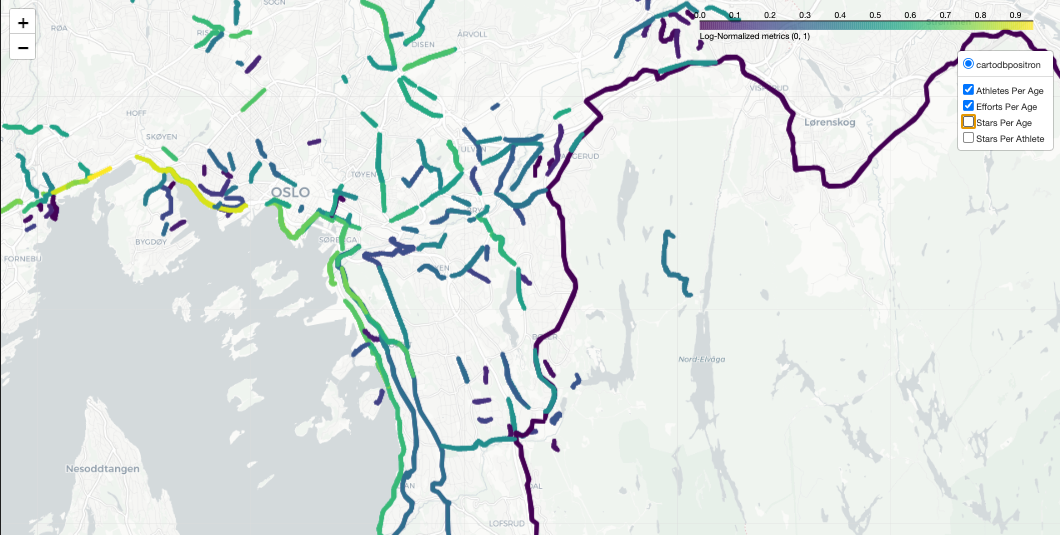

It seems efforts per age might be the best way to represent popularity. 

## Display vectors as gdf

In [55]:
from IPython.display import display

if vector_files:
    # --- Create Base Map --- 
    # Load the first file to get bounds for centering the map
    try:
        first_gdf = gpd.read_file(vector_files[0])
        # Reproject to WGS84 for Folium
        first_gdf_wgs84 = first_gdf.to_crs(epsg=4326)
        map_center = first_gdf_wgs84.geometry.unary_union.centroid.coords[0][::-1] # Reverse (lat, lon)
        m = folium.Map(location=map_center, zoom_start=12, tiles='CartoDB positron')
    except Exception as e:
        print(f"Error loading first file {vector_files[0]} to center map: {e}. Creating default map.")
        m = folium.Map(location=[59.9139, 10.7522], zoom_start=11, tiles='CartoDB positron') # Default Oslo center

    # --- Add each vector file as a layer --- 
    for vector_file in vector_files:
        print(f"Processing {vector_file.name}...")
        gdf = gpd.read_file(vector_file)
        gdf["avg_speed_kmh"] = gdf["average_speed"] * 3.6
        display(gdf.describe())
        display(gdf.sort_values(by="split").head(30))
            

/var/folders/9t/2ktxww317sjf49by2n8qnpb80000gp/T/ipykernel_92024/3016113629.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  map_center = first_gdf_wgs84.geometry.unary_union.centroid.coords[0][::-1] # Reverse (lat, lon)


Processing average_speed_vector.gpkg...


,activity_id,split,average_speed,split_dist_m,avg_speed_kmh
count,2.331000e+03,2331.000000,2331.000000,2331.000000,2331.000000
mean,5.040875e+09,19.794938,6.738078,978.184384,24.257081
std,3.183408e+09,17.039590,1.901543,121.511500,6.845556
min,2.514657e+09,1.000000,0.010000,2.100000,0.036000
25%,3.473849e+09,7.000000,5.490000,994.800000,19.764000
50%,3.810779e+09,15.000000,6.700000,999.900000,24.120000
75%,4.055116e+09,28.000000,7.975000,1004.400000,28.710000
max,1.418665e+10,91.000000,14.230000,1059.200000,51.228000


,activity_id,split,average_speed,split_dist_m,geometry,avg_speed_kmh
0,3654637676,1,4.19,1001.1,"LINESTRING (260735.728 6651858.531, 260689.841...",15.084
2090,4017441614,1,5.69,1046.1,"LINESTRING (261288.548 6651177.247, 261293.986...",20.484
2060,3509405722,1,5.87,1003.4,"LINESTRING (261035.063 6651374.562, 261019.325...",21.132
531,3882314674,1,5.83,1003.6,"LINESTRING (261297.736 6651128.632, 261287.346...",20.988
2044,4101804951,1,6.80,1006.7,"LINESTRING (265633.482 6652095.965, 265586.967...",24.480
1967,3899200592,1,3.72,1040.2,"LINESTRING (261332.325 6651446.909, 261336.52 ...",13.392
1964,14138858292,1,5.66,1007.3,"LINESTRING (264486.004 6649248.872, 264478.54 ...",20.376
1926,3810778762,1,2.72,1021.3,"LINESTRING (261252.785 6651196.311, 261230.419...",9.792
622,9539966034,1,4.89,1011.8,"LINESTRING (264615.335 6649210.48, 264628.959 ...",17.604
639,3810778863,1,7.87,1007.1,"LINESTRING (261260.843 6651104.215, 261283.045...",28.332


Processing prepared_activity_splits.gpkg...


,activity_id,split,average_speed,split_dist_m,avg_speed_kmh
count,2.331000e+03,2331.000000,2331.000000,2331.000000,2331.000000
mean,5.040875e+09,19.794938,6.738078,978.184384,24.257081
std,3.183408e+09,17.039590,1.901543,121.511500,6.845556
min,2.514657e+09,1.000000,0.010000,2.100000,0.036000
25%,3.473849e+09,7.000000,5.490000,994.800000,19.764000
50%,3.810779e+09,15.000000,6.700000,999.900000,24.120000
75%,4.055116e+09,28.000000,7.975000,1004.400000,28.710000
max,1.418665e+10,91.000000,14.230000,1059.200000,51.228000


,activity_id,split,average_speed,split_dist_m,geometry,avg_speed_kmh
0,3654637676,1,4.19,1001.1,"LINESTRING (260735.728 6651858.531, 260689.841...",15.084
2090,4017441614,1,5.69,1046.1,"LINESTRING (261288.548 6651177.247, 261293.986...",20.484
2060,3509405722,1,5.87,1003.4,"LINESTRING (261035.063 6651374.562, 261019.325...",21.132
531,3882314674,1,5.83,1003.6,"LINESTRING (261297.736 6651128.632, 261287.346...",20.988
2044,4101804951,1,6.80,1006.7,"LINESTRING (265633.482 6652095.965, 265586.967...",24.480
1967,3899200592,1,3.72,1040.2,"LINESTRING (261332.325 6651446.909, 261336.52 ...",13.392
1964,14138858292,1,5.66,1007.3,"LINESTRING (264486.004 6649248.872, 264478.54 ...",20.376
1926,3810778762,1,2.72,1021.3,"LINESTRING (261252.785 6651196.311, 261230.419...",9.792
622,9539966034,1,4.89,1011.8,"LINESTRING (264615.335 6649210.48, 264628.959 ...",17.604
639,3810778863,1,7.87,1007.1,"LINESTRING (261260.843 6651104.215, 261283.045...",28.332
